In [1]:
# import libraries needed
import numpy as np
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import plot_model
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers
from tensorflow.keras import regularizers

tf.random.set_seed(42)
np.random.seed(42)
RSEED=42

df = pd.read_csv('../../data/data_with_target.csv', index_col=0)

In [2]:
mfcc = [col for col in df.columns if col.startswith('mfcc')] 
chroma = [col for col in df.columns if col.startswith('chroma')]
rmse = [col for col in df.columns if col.startswith('rmse')]
zcr = [col for col in df.columns if col.startswith('zcr')]
spectral = [col for col in df.columns if col.startswith('spectral')]
tonnetz = [col for col in df.columns if col.startswith('tonnetz')]


df = df[['track_genre_top','track_bit_rate','track_duration', 'album_tracks', 'album_information_bin','other_website', 'soundcloud_website', 'artist_bio_bin', 'listens_bins']]
        #including different combinations of audio features were tried, but let to worsening of model performance
        #['rmse_kurtosis_01']]
        #mfcc_mean + mfcc_std]#+chroma+rmse+zcr+spectral]#+tonnetz]

df['track_genre_top'].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [3]:
df

,track_genre_top,track_bit_rate,track_duration,album_tracks,album_information_bin,other_website,soundcloud_website,artist_bio_bin,listens_bins
Unnamed: 0,,,,,,,,,
0,Hip-Hop,256000,168,7,1,True,False,1,2
1,Hip-Hop,256000,206,7,1,True,False,1,1
2,Pop,192000,161,2,0,True,False,1,4
3,Folk,128000,253,1,1,True,False,1,2
4,Folk,128000,182,2,1,True,False,1,1
...,...,...,...,...,...,...,...,...,...
7995,Hip-Hop,320000,194,18,0,False,True,1,4
7996,Hip-Hop,320000,162,18,0,False,True,1,4
7997,Pop,320000,349,11,1,False,False,1,2


Split into train, validation and test-sets

In [4]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

Dealing with categorical data on features

In [5]:
# for train features
encoded_categories = pd.get_dummies(train_df['track_genre_top'], drop_first=True)
train_df = pd.concat([train_df, encoded_categories], axis=1)
train_df.drop('track_genre_top', axis=1, inplace=True)
train_df.head()

# for validation features
encoded_categories = pd.get_dummies(val_df['track_genre_top'], drop_first=True)
val_df = pd.concat([val_df, encoded_categories], axis=1)
val_df.drop('track_genre_top', axis=1, inplace=True)
val_df.head()

# for test features
encoded_categories = pd.get_dummies(test_df['track_genre_top'], drop_first=True)
test_df = pd.concat([test_df, encoded_categories], axis=1)
test_df.drop('track_genre_top', axis=1, inplace=True)
test_df.head()

,track_bit_rate,track_duration,album_tracks,album_information_bin,other_website,soundcloud_website,artist_bio_bin,listens_bins,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
Unnamed: 0,,,,,,,,,,,,,,,
2215,320000,209,12,1,True,False,0,4,False,False,False,False,False,True,False
2582,256000,275,31,1,False,False,1,3,False,False,False,False,False,False,True
1662,256000,255,32,1,True,False,1,3,False,False,False,False,True,False,False
3027,320000,265,9,1,True,False,1,4,False,False,False,False,False,False,False
4343,228446,494,19,1,False,True,1,4,False,False,False,False,False,False,False


In [6]:
print(f'The shape of test_df is {train_df.shape}')
print(f'The shape of val_df is {val_df.shape}')
print(f'The shape of test_df is {test_df.shape}')

The shape of test_df is (5120, 15)
The shape of val_df is (1280, 15)
The shape of test_df is (1600, 15)


In [7]:
train_df.head()

,track_bit_rate,track_duration,album_tracks,album_information_bin,other_website,soundcloud_website,artist_bio_bin,listens_bins,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
Unnamed: 0,,,,,,,,,,,,,,,
7806,320000,235,17,0,False,True,1,4,False,False,False,True,False,False,False
2734,320000,227,14,1,True,False,1,2,False,True,False,False,False,False,False
1522,320000,212,18,1,True,False,1,1,False,False,False,False,False,True,False
6795,320000,165,21,0,False,False,1,4,False,False,False,False,False,False,True
5350,320000,166,9,1,True,False,1,3,False,False,False,True,False,False,False


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5120 entries, 7806 to 691
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   track_bit_rate         5120 non-null   int64
 1   track_duration         5120 non-null   int64
 2   album_tracks           5120 non-null   int64
 3   album_information_bin  5120 non-null   int64
 4   other_website          5120 non-null   bool 
 5   soundcloud_website     5120 non-null   bool 
 6   artist_bio_bin         5120 non-null   int64
 7   listens_bins           5120 non-null   int64
 8   Experimental           5120 non-null   bool 
 9   Folk                   5120 non-null   bool 
 10  Hip-Hop                5120 non-null   bool 
 11  Instrumental           5120 non-null   bool 
 12  International          5120 non-null   bool 
 13  Pop                    5120 non-null   bool 
 14  Rock                   5120 non-null   bool 
dtypes: bool(9), int64(6)
memory usage: 325.0 

Convert int64 columns to float64

In [9]:
train_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']] = train_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']].astype('float64')
val_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']] = val_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']].astype('float64')
test_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']] = test_df[['track_bit_rate','track_duration','album_information_bin','other_website', 'soundcloud_website']].astype('float64')

Lower case all genre columns

In [10]:
train_df.columns = map(str.lower, train_df.columns)
val_df.columns = map(str.lower, val_df.columns)
test_df.columns = map(str.lower, test_df.columns)

In [11]:
train_df

,track_bit_rate,track_duration,album_tracks,album_information_bin,other_website,soundcloud_website,artist_bio_bin,listens_bins,experimental,folk,hip-hop,instrumental,international,pop,rock
Unnamed: 0,,,,,,,,,,,,,,,
7806,320000.0,235.0,17,0.0,0.0,1.0,1,4,False,False,False,True,False,False,False
2734,320000.0,227.0,14,1.0,1.0,0.0,1,2,False,True,False,False,False,False,False
1522,320000.0,212.0,18,1.0,1.0,0.0,1,1,False,False,False,False,False,True,False
6795,320000.0,165.0,21,0.0,0.0,0.0,1,4,False,False,False,False,False,False,True
5350,320000.0,166.0,9,1.0,1.0,0.0,1,3,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,160000.0,110.0,23,1.0,1.0,0.0,0,4,False,False,False,True,False,False,False
724,256000.0,310.0,13,1.0,1.0,0.0,1,4,False,False,False,False,False,False,True
4258,320000.0,231.0,8,0.0,0.0,0.0,1,3,False,False,False,False,False,False,True


Convert genre columns from object to float64 type

In [12]:
genre_list = ['hip-hop', 'pop', 'folk', 'experimental', 'rock', 'international', 'instrumental']
train_df[genre_list] = train_df[genre_list].astype('float64')
val_df[genre_list] = val_df[genre_list].astype('float64')
test_df[genre_list] = test_df[genre_list].astype('float64')

In [13]:
# form np arrays of labels and features.
train_labels = np.array(train_df.pop('listens_bins'))
val_labels = np.array(val_df.pop('listens_bins'))
test_labels = np.array(test_df.pop('listens_bins'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   2.5066
Average class probability in validation set: 2.4945
Average class probability in test set:       2.5081


Scaling data on train set only (avoidd data leakage)

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

2023-12-18 13:01:41.764814: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-18 13:01:41.764845: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-18 13:01:41.764851: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-18 13:01:41.765162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 13:01:41.765421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-18 13:01:41.943721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [15]:
# defining a custom Cohen's Kappa metric
class CohenKappa(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='cohen_kappa', **kwargs):
        super(CohenKappa, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.y_true = self.add_weight(name='y_true', shape=(num_classes,), initializer='zeros')
        self.y_pred = self.add_weight(name='y_pred', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)

        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
        y_pred_one_hot = tf.one_hot(y_pred, depth=self.num_classes)

        self.y_true.assign_add(tf.reduce_sum(y_true_one_hot, axis=0))
        self.y_pred.assign_add(tf.reduce_sum(y_pred_one_hot, axis=0))

    def result(self):
        y_true = tf.cast(self.y_true, dtype=tf.int32)
        y_pred = tf.cast(self.y_pred, dtype=tf.int32)

        numerator = tf.reduce_sum(tf.cast(y_true * y_pred, dtype=tf.float32))
        denominator = tf.reduce_sum(tf.cast(y_true, dtype=tf.float32)) * tf.reduce_sum(tf.cast(y_pred, dtype=tf.float32))
        cohen_kappa = 1 - (1.0 * numerator / denominator)
        return cohen_kappa

    def reset_states(self):
        self.y_true.assign(tf.zeros_like(self.y_true))
        self.y_pred.assign(tf.zeros_like(self.y_pred))

In [16]:
# define number of classes = 4 as we have 4 bins
num_classes = 4

In [17]:
from tensorflow.keras.layers import Dropout

model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(512, activation='relu'),  #Dense layer with 4 nodes and gelu act.
    tf.keras.layers.Dense(256, activation='relu'), #Hidden layer with 4 nodes and gelu act.
    #Dropout(0.2), #Dropout layer randomly sets input units to 0 --> prevent overfitting
    tf.keras.layers.Dense(256, activation='relu'), #2nd hidden layer
    tf.keras.layers.Dense(4, activation='softmax') #Output layer, softmax for multi-class classification
 ])
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.000109) # initial value 0.0005
model.compile(optimizer=opt,
            loss='categorical_crossentropy',
            metrics=[CohenKappa(num_classes=num_classes)])

In [18]:
# instantiate small model and print model summary
with tf.device('/cpu:0'):
    model = model
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 14)                29        
 on)                                                             
                                                                 
 dense (Dense)               (None, 512)               7680      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 205857 (804.13 KB)
Trainable params: 205828 (804.02 KB)
Non-trainable params: 29 (120.00 Byte)
_____________

In [19]:
from tensorflow.keras.utils import to_categorical

# required to one hot encode labels to feed into neural network
train_labels_one_hot = to_categorical(train_labels, num_classes=6) #class index starts with 0
val_labels_one_hot = to_categorical(val_labels, num_classes=6)
test_labels_one_hot = to_categorical(test_labels, num_classes=6)

# put them into a pd dataframe
train_labels_one_hot = pd.DataFrame(train_labels_one_hot)
val_labels_one_hot = pd.DataFrame(val_labels_one_hot)
test_labels_one_hot = pd.DataFrame(test_labels_one_hot)

# while one hot encoding, unnecessary "border" columns were created, these need to be dropped, otherwise dimensionality does not match up 
train_labels_one_hot.drop(0, axis=1, inplace=True)
val_labels_one_hot.drop(0, axis=1, inplace=True)
test_labels_one_hot.drop(0, axis=1, inplace=True)

train_labels_one_hot.drop(5, axis=1, inplace=True)
val_labels_one_hot.drop(5, axis=1, inplace=True)
test_labels_one_hot.drop(5, axis=1, inplace=True)

# put them back into a np.array to be used for NN
train_labels_one_hot = np.array(train_labels_one_hot)
val_labels_one_hot = np.array(val_labels_one_hot)
test_labels_one_hot = np.array(test_labels_one_hot)

In [20]:
print(f'{train_labels.shape}')
print(f'{train_labels_one_hot.shape}')

(5120,)
(5120, 4)


In [21]:
training = model.fit(
    train_features,
    train_labels_one_hot,
    batch_size=256,
    epochs=10,
    validation_data=(val_features, val_labels_one_hot), 
    verbose=1)

Epoch 1/10


20/20 [==============================] - 1s 25ms/step - loss: 1.2575 - cohen_kappa: 0.7507 - val_loss: 1.1835 - val_cohen_kappa: 0.7564
Epoch 2/10
 1/20 [>.............................] - ETA: 0s - loss: 1.1544 - cohen_kappa: 0.7512

/Users/jinsunij/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


20/20 [==============================] - 0s 18ms/step - loss: 1.1606 - cohen_kappa: 0.7512 - val_loss: 1.1494 - val_cohen_kappa: 0.7567
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 1.1312 - cohen_kappa: 0.7512 - val_loss: 1.1279 - val_cohen_kappa: 0.7560
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 1.1155 - cohen_kappa: 0.7512 - val_loss: 1.1147 - val_cohen_kappa: 0.7562
Epoch 5/10
20/20 [==============================] - 0s 25ms/step - loss: 1.1049 - cohen_kappa: 0.7509 - val_loss: 1.1060 - val_cohen_kappa: 0.7554
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 1.0974 - cohen_kappa: 0.7510 - val_loss: 1.1028 - val_cohen_kappa: 0.7562
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 1.0940 - cohen_kappa: 0.7510 - val_loss: 1.0986 - val_cohen_kappa: 0.7545
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 1.0909 - cohen_kappa: 0.7510 - val_loss: 1.0940 - val_co

Prediction and model performance on test data

In [22]:
# prediction on test data
y_pred = model.predict(test_features)

y_pred = np.argmax(y_pred, axis=1) #np.argmax(softmax_output, axis=1) returns an array containing the indices of the predicted classes based on the highest probability in each row of the softmax output.

50/50 [==============================] - 0s 2ms/step


In [23]:
conf_matrix= confusion_matrix(np.argmax(test_labels_one_hot, axis=1), y_pred)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(np.argmax(test_labels_one_hot, axis=1), y_pred, weights='linear').round(3))

51.1
33.9
10.9
4.1
--------------------------------
0.49


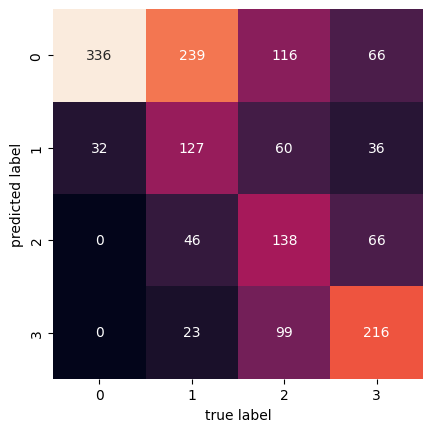

In [24]:
# plotting the confusing matrix
mat = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [25]:
x = np.argmax(test_labels_one_hot, axis=1)
x.shape

(1600,)

Prediction and model performance on train data

In [26]:
# prediction on train data
y_pred_train = model.predict(train_features)

y_pred_train = np.argmax(y_pred_train, axis=1) #np.argmax(softmax_output, axis=1) returns an array containing the indices of the predicted classes based on the highest probability in each row of the softmax output.

160/160 [==============================] - 1s 3ms/step


In [27]:
# score on train data
print(cohen_kappa_score(np.argmax(train_labels_one_hot, axis=1), y_pred_train, weights='linear').round(3))

0.496
